In [1]:
# 🔧 Eenmalig uitvoeren als je dit notebook voor het eerst draait in een nieuwe omgeving
!pip install pycoingecko torch scikit-learn matplotlib pandas numpy mplfinance streamlit

Defaulting to user installation because normal site-packages is not writeable


In [2]:
!python3 -m streamlit run dashboard.py




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://10.0.2.15:8501
  External URL: http://83.87.201.250:8501

────────────────────────── Traceback (most recent call last) ───────────────────────────
  /home/skaffaai/.local/lib/python3.10/site-packages/streamlit/runtime/scriptrunner/ex  
  ec_code.py:128 in exec_func_with_error_handling                                       
                                                                                        
  /home/skaffaai/.local/lib/python3.10/site-packages/streamlit/runtime/scriptrunner/sc  
  ript_runner.py:669 in code_to_exec                                                    
                                                                                        
  /home/skaffaai/ai-projects/notebooks/dashboard.py:23 in <module>                      
                                                                                        
    20 │   else:         

Selectie:
1. Eénmalige run
2. Continue mode
3. Vergelijk laatste runs
4. Exit


Kies (1/2/3/4):  3
Aantal laatste runs:  18


Overzicht van de laatste 18 runs:
        coin timeframe       mse       mae        r2    pnl_usd
36  BTC/USDT       15m  0.050328  0.199625 -0.869037   4.566177
37  BTC/USDT        1h  0.045920  0.171037  0.378663   3.821647
38  BTC/USDT        4h  0.044869  0.194505 -0.378690   2.916648
39  ETH/USDT       15m  0.033006  0.159914  0.411377   2.734490
40  ETH/USDT        1h  0.077891  0.220121  0.075136   3.817852
41  ETH/USDT        4h  0.040972  0.193644 -0.305712   3.342878
42  SOL/USDT       15m  0.024743  0.113876  0.532248   4.604004
43  SOL/USDT        1h  0.039849  0.179126  0.511835   7.161066
44  SOL/USDT        4h  0.035247  0.150067  0.315467   6.187727
45  SUI/USDT       15m  0.022701  0.133716  0.426935  10.991027
46  SUI/USDT        1h  0.083376  0.267859  0.058906   3.742454
47  SUI/USDT        4h  0.027093  0.143495  0.549232   5.128940
48  ADA/USDT       15m  0.092703  0.264817 -0.353911   5.417779
49  ADA/USDT        1h  0.045843  0.191496  0.477207   4.339638
50  AD

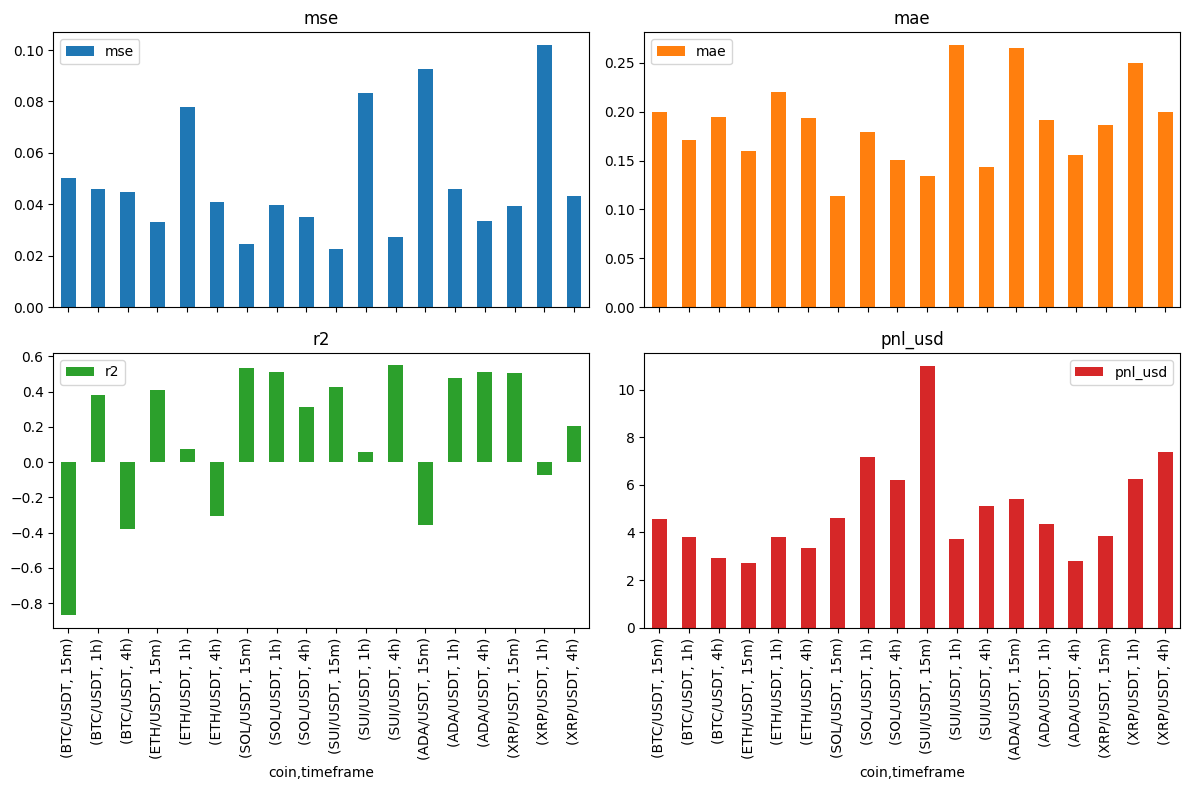

In [6]:
import os
import datetime
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import ccxt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import time
import mplfinance as mpf

# --- Configuratie ---
DATA_DIR = "./data"
CACHE_EXPIRY_DAYS = 1
LIMIT_MAP = {"15m": 3000, "1h": 2000, "4h": 1500}

COINS = ["BTC/USDT", "ETH/USDT", "SOL/USDT", "SUI/USDT", "ADA/USDT", "XRP/USDT"]
TIMEFRAMES = ["15m", "1h", "4h"]
SEQ_LEN = 60
WINDOW_SIZE = 300
STEP_SIZE = 100
EPOCHS = 50
LEARNING_RATE = 0.001
MODEL_DIR = "./models"
LOG_DIR = "./logs"

# --- Model ---
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=64, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            dropout=dropout, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])
        return self.linear(out).squeeze()

# --- Helpers for data ---
def merge_and_cache_df(existing_df, new_df, timeframe):
    merged = pd.concat([existing_df, new_df]).sort_index().drop_duplicates()
    limit = LIMIT_MAP.get(timeframe, SEQ_LEN + WINDOW_SIZE)
    return merged.iloc[-limit:]

def load_or_fetch_data(exchange, coin, timeframe):
    limit = LIMIT_MAP[timeframe]
    folder = os.path.join(DATA_DIR, coin.replace('/','_'))
    os.makedirs(folder, exist_ok=True)
    fname = os.path.join(folder, f"{timeframe}.csv")
    if os.path.exists(fname) and (time.time()-os.path.getmtime(fname))/86400 < CACHE_EXPIRY_DAYS:
        df_old = pd.read_csv(fname, parse_dates=['timestamp'], index_col='timestamp')
        since = int(df_old.index[-1].timestamp()*1000)
        raw = exchange.fetch_ohlcv(coin, timeframe=timeframe, since=since, limit=limit)
        df_new = pd.DataFrame(raw, columns=['timestamp','open','high','low','close','volume'])
        df_new['timestamp']=pd.to_datetime(df_new['timestamp'],unit='ms')
        df_new.set_index('timestamp', inplace=True)
        df = merge_and_cache_df(df_old, df_new, timeframe)
    else:
        raw = exchange.fetch_ohlcv(coin, timeframe=timeframe, limit=limit)
        df = pd.DataFrame(raw, columns=['timestamp','open','high','low','close','volume'])
        df['timestamp']=pd.to_datetime(df['timestamp'],unit='ms')
        df.set_index('timestamp', inplace=True)
    df.to_csv(fname)
    return df

# --- Indicators & preprocessing ---
def add_indicators(df):
    # EMA, RSI, Bollinger
    df['ema'] = df['close'].ewm(span=14, adjust=False).mean()
    delta = df['close'].diff(); up = delta.clip(lower=0); down = -delta.clip(upper=0)
    rs = up.rolling(14).mean()/down.rolling(14).mean()
    df['rsi'] = 100 - (100/(1+rs))
    df['bb_mid'] = df['close'].rolling(20).mean(); df['bb_std'] = df['close'].rolling(20).std()
    df['bb_upper'] = df['bb_mid']+2*df['bb_std']; df['bb_lower'] = df['bb_mid']-2*df['bb_std']
    # MACD
    ema12 = df['close'].ewm(span=12, adjust=False).mean()
    ema26 = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = ema12-ema26
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    # OBV
    df['obv'] = (np.sign(df['close'].diff())*df['volume']).fillna(0).cumsum()
    # ATR
    high_low = df['high']-df['low']
    high_close = (df['high']-df['close'].shift()).abs()
    low_close  = (df['low']-df['close'].shift()).abs()
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    df['atr'] = tr.rolling(14).mean()
    # StochRSI
    df['rsi_min'] = df['rsi'].rolling(14).min(); df['rsi_max'] = df['rsi'].rolling(14).max()
    df['stoch_rsi'] = (df['rsi']-df['rsi_min'])/(df['rsi_max']-df['rsi_min'])
    # Volume SMA
    df['vol_sma'] = df['volume'].rolling(20).mean()
    df.dropna(inplace=True)
    # Outlier filter
    df = df[(df['close']<df['ema']*1.3)&(df['close']>df['ema']*0.7)]
    return df

# --- Sequences ---
def create_sequences(data, seq_len):
    xs, ys = [], []
    for i in range(len(data)-seq_len-2):
        xs.append(data[i:i+seq_len]); ys.append(np.mean(data[i+seq_len:i+seq_len+3,0]))
    return np.array(xs), np.array(ys)

# --- Metrics ---
def evaluate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2  = r2_score(y_true, y_pred)
    return mse, mae, r2

# --- Evaluation plots ---
def plot_evaluation(X, y, preds_full, train_losses, val_losses, coin, tf):
    corr = np.corrcoef(preds_full, y[:len(preds_full)])[0,1]
    plt.scatter(y[:300], preds_full[:300], s=5)
    plt.title(f"Scatter {coin}[{tf}] R={corr:.2f}"); plt.show()
    plt.plot(y[:200], label='Actual'); plt.plot(preds_full[:200], label='Pred'); plt.title(f"Overlay {coin}[{tf}]"); plt.legend(); plt.show()
    pnls=[]
    for i in range(len(preds_full)-1):
        if preds_full[i+1]>preds_full[i]: pnls.append((X[i+1,-1,0]-X[i,-1,0])/X[i,-1,0])
    plt.plot(np.cumsum(pnls)); plt.title(f"Equity {coin}[{tf}]"); plt.show()
    for losses in train_losses: plt.plot(losses, alpha=0.3)
    plt.title('Train loss per fold'); plt.show()
    for losses in val_losses: plt.plot(losses, alpha=0.3)
    plt.title('Val loss per fold'); plt.show()

def save_model(model, coin, timeframe, folder="models"):
    os.makedirs(folder, exist_ok=True)
    filename = f"{folder}/{coin.replace('/', '_')}_{timeframe}_model.pth"
    torch.save(model.state_dict(), filename)
    print(f"✅ Model opgeslagen: {filename}")

def load_model(model, coin, timeframe, folder="models"):
    filename = f"{folder}/{coin.replace('/', '_')}_{timeframe}_model.pth"
    if os.path.exists(filename):
        model.load_state_dict(torch.load(filename))
        model.eval()
        print(f"✅ Model geladen: {filename}")
    else:
        print(f"⚠️ Geen modelbestand gevonden: {filename}")

# --- Main pipeline ---
def run_pipeline():
    exchange = ccxt.mexc()
    start_all = time.time()
    for coin in COINS:
        for tf in TIMEFRAMES:
            print(f"🚀 {coin}[{tf}] 5-fold CV met early stopping")
            # --- Load and preprocess data with caching ---
            df = load_or_fetch_data(exchange, coin, tf)
            # Save preprocessed cache
            preproc_folder = os.path.join(DATA_DIR, coin.replace('/','_'))
            proc_file = os.path.join(preproc_folder, f"preprocessed_{tf}_{datetime.datetime.now().strftime('%Y%m%d_%H%M')}.csv")
            df = add_indicators(df)
            df.to_csv(proc_file)
            # --- Pre-train validation & automatic drop ---
            min_rows = SEQ_LEN * 2 + WINDOW_SIZE + 3
            if len(df) < min_rows:
                print(f"Dataset te klein na indicators ({len(df)} < {min_rows}), overslaan...")
                continue
            if df['close'].std() < 1e-3:
                print(f"Dataset te vlak (std={df['close'].std():.6f}), overslaan...")
                continue
            # Prepare sequences
            arr = df[['close','ema','rsi','bb_upper','bb_lower','macd','obv','atr','stoch_rsi','vol_sma']].values
            scaled = MinMaxScaler().fit_transform(arr)
            X, y = create_sequences(scaled, SEQ_LEN)
            if len(X) < 5:
                print(f"Te weinig samples voor CV: {len(X)} < 5, overslaan...")
                continue
            # ... rest of CV and training loop unchanged ...
        for tf in TIMEFRAMES:
            print(f"\n🚀 {coin}[{tf}] 5-fold CV met early stopping")
            df = load_or_fetch_data(exchange, coin, tf)
            df = add_indicators(df)
            arr = df[['close','ema','rsi','bb_upper','bb_lower','macd','obv','atr','stoch_rsi','vol_sma']].values
            if len(arr)<SEQ_LEN*2:
                print("Te weinig data voor CV"); continue
            scaled=MinMaxScaler().fit_transform(arr)
            X, y = create_sequences(scaled, SEQ_LEN)
            if len(X)<5:
                print("Te weinig samples voor 5-fold"); continue
            kf=KFold(n_splits=5, shuffle=False)
            best_state, best_val=float('inf'),None
            train_losses, val_losses=[],[]
            for fold,(tr,vl) in enumerate(kf.split(X),1):
                Xtr,Xvl=X[tr],X[vl]; ytr,yvl=y[tr],y[vl]
                Xt, Yt = torch.tensor(Xtr).float(), torch.tensor(ytr).float()
                Xv, Yv = torch.tensor(Xvl).float(), torch.tensor(yvl).float()
                model=LSTMModel(input_size=X.shape[2])
                opt=optim.Adam(model.parameters(),lr=LEARNING_RATE); crit=nn.MSELoss()
                patience,wait=5,0; tl,vlosses=[],[]
                for ep in range(EPOCHS):
                    model.train()
                    opt.zero_grad()
                    l = crit(model(Xt), Yt)
                    l.backward()
                    opt.step()
                    tl.append(l.item())
                    # Validation step
                    model.eval()
                    v = crit(model(Xv), Yv).item()
                    vlosses.append(v)
                    # Check for best model
                    if best_val is None or v < best_val:
                        best_val = v
                        best_state = model.state_dict().copy()
                        wait = 0
                    else:
                        wait += 1
                        if wait >= patience:
                            print(f"Early stop fold {fold} epoch {ep+1}")
                            break
                train_losses.append(tl)
                val_losses.append(vlosses)
            # finalize
            model.load_state_dict(best_state); model.eval()
            preds_full = model(torch.tensor(X).float()).detach().numpy().flatten()
            # plots
            plot_evaluation(X,y,preds_full,train_losses,val_losses,coin,tf)
            # save
            save_model(model, coin, tf)
            # tekst stats per coin/timeframe
            mse,mae,r2=evaluate_metrics(y[:len(preds_full)],preds_full)
            corr=np.corrcoef(y[:len(preds_full)],preds_full)[0,1]
            train_gap=np.mean([abs(tl[-1]-vl[-1]) for tl,vl in zip(train_losses,val_losses)])
            prices=X[:len(preds_full), -1,0]
            returns=[(prices[i+1]-prices[i])/prices[i] for i in range(len(prices)-1) if preds_full[i+1]>preds_full[i]]
            equity=np.cumsum(returns)
            sharpe=(np.mean(returns)/ (np.std(returns)+1e-8)) if returns else 0
            winrate=(sum(r>0 for r in returns)/len(returns)) if returns else 0
            max_dd=np.max(np.maximum.accumulate(equity)-equity) if equity.size else 0
            bh=(prices[-1]-prices[0])/prices[0]
            print(f"📊 Overzicht {coin}[{tf}]:")
            # --- Append run metrics to CSV ---
            row = {
                'timestamp': datetime.datetime.now().isoformat(),
                'coin': coin,
                'timeframe': tf,
                'mse': mse,
                'mae': mae,
                'r2': r2,
                'corr': corr,
                'train_val_gap': train_gap,
                'winrate': winrate,
                'sharpe': sharpe,
                'max_dd': max_dd,
                'pnl_usd': float(equity[-1])
            }
            csv_path = os.path.join(LOG_DIR, 'metrics.csv')
            df_row = pd.DataFrame([row])
            if os.path.exists(csv_path):
                df_old = pd.read_csv(csv_path)
                df_new = pd.concat([df_old, df_row], ignore_index=True)
            else:
                df_new = df_row
            df_new.to_csv(csv_path, index=False)
            print(f" MSE: {mse:.6f} | MAE: {mae:.6f} | R²: {r2:.3f} | Corr: {corr:.3f}")
            print(f" Train–Val gap: {train_gap:.6f}")
            print(f" Winrate: {winrate*100:.1f}% | Sharpe: {sharpe:.2f} | Max DD: {max_dd*100:.1f}%")
            print(f" Model Equity vs B&H: {equity[-1]:.4f} vs {bh:.4f}\n")
    print(f"⏱️ Done in {time.time()-start_all:.2f}s")

# --- Menu ---
def continuous_trading(interval=900):
    try:
        while True:
            run_pipeline(); print(f"Wachten {interval}s..."); time.sleep(interval)
    except KeyboardInterrupt:
        print("Continue trading gestopt.")

if __name__=='__main__':
    print("Selectie:\n1. Eénmalige run\n2. Continue mode\n3. Vergelijk laatste runs\n4. Exit")
    choice=input("Kies (1/2/3/4): ")
    if choice=='1': run_pipeline()
    elif choice=='2': continuous_trading()
    elif choice=='3':
        try:
            dfm = pd.read_csv(os.path.join(LOG_DIR, 'metrics.csv'))
            x = int(input("Aantal laatste runs: "))
            last = dfm.tail(x)
            # Bepaal beschikbare columns
            cols = ['coin', 'timeframe', 'mse', 'mae', 'r2', 'pnl_usd']
            available = [c for c in cols if c in last.columns]
            print(f"Overzicht van de laatste {x} runs:")
            print(last[available])
            last.set_index(['coin','timeframe'], inplace=True)
            # Plot only available metrics
            plot_cols = [c for c in ['mse','mae','r2','pnl_usd'] if c in last.columns]
            if plot_cols:
                last[plot_cols].plot(kind='bar', subplots=True, layout=(2,2), figsize=(12,8))
                plt.tight_layout()
                plt.show()
        except Exception as e:
            print(f"Fout bij vergelijking: {e}")
    else:
        print("Einde programma.")
